In [2]:
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
from keras import layers

In [3]:
#Coletando dados 

df = pd.read_excel('/home/andre/Área de Trabalho/Reconstrução da Estatística Pesqueira BR/Rio de Janeiro/Peixes/Sciaenidae/RJ_Reconstrucao_Sciaenidae_2024_08_06.xlsx')
df_Fofa_art = pd.DataFrame(df[['Ano','Fofa_art']])

dados = df_Fofa_art.dropna()
anos_com_dados = dados["Ano"].values
anos_para_prever = np.array([2022])
todos_anos = np.concatenate((anos_para_prever, anos_com_dados))
todos_anos.sort()

pesca = dados['Fofa_art'].values
dados.head()

,Ano,Fofa_art
67,2017,0.1484
68,2018,0.1532
69,2019,0.0406
70,2020,0.1058
71,2021,0.0177


In [4]:
#Normalização dos dados

ano_mean = np.mean(anos_com_dados)
ano_std = np.std(anos_com_dados)
anos_para_prever_norm = (anos_para_prever - ano_mean)/ano_std
anos_com_dados_norm = (anos_com_dados - ano_mean)/ano_std

pesca_mean = np.mean(pesca)
pesca_std = np.std(pesca)
pesca_norm = (pesca - pesca_mean)/pesca_std

In [12]:
#Fit do modelo e salvando seus pesos
model = keras.Sequential([layers.Dense(96,activation='leaky_relu',input_shape=(1,)),
                             layers.Dense(32,activation='leaky_relu'),
                             layers.Dense(80,activation='leaky_relu'),
                             layers.Dense(80,activation='leaky_relu'),
                             layers.Dense(96,activation='leaky_relu'),
                             layers.Dense(112,activation='leaky_relu'),
                             layers.Dense(1,activation='linear')])

opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mse')


history = model.fit(anos_com_dados_norm,pesca_norm, epochs=50, verbose=1)
model.save_weights('/home/andre/Área de Trabalho/Reconstrução da Estatística Pesqueira BR/Rio de Janeiro/Peixes/Sciaenidae/Fofa/pesos pesca art/.weights.h5', overwrite=True)

Epoch 1/50


/home/andre/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step - loss: 1.0116
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.9597
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.9118
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.8654
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.8151
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.7583
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6941
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6258
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.5548
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.4833
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.4183
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3684
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.3436
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3498
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3777
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms

In [10]:
#Pegando os pesos salvos
model.load_weights('/home/andre/Área de Trabalho/Reconstrução da Estatística Pesqueira BR/Rio de Janeiro/Peixes/Sciaenidae/Fofa/pesos pesca art/.weights.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Previsões dos dados ausentes: [[0.02659433]]


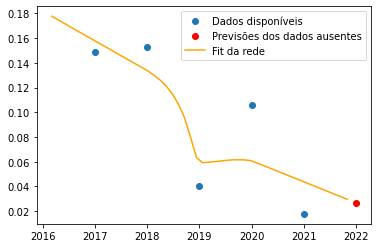

In [13]:
#Previsões
prev_disponiveis = model.predict(anos_com_dados_norm)*pesca_std + pesca_mean
prev_ausentes = model.predict(anos_para_prever_norm)*pesca_std + pesca_mean

#Colocando valores negativos para 0
for i in range(len(prev_ausentes)):
    if prev_ausentes[i]<0:
        prev_ausentes[i]=0

#Plot dos dados e previsões
f1=plt.figure(1).add_subplot()
f1.scatter(anos_com_dados,pesca,label='Dados disponíveis')
f1.scatter(anos_para_prever,prev_ausentes, color='red', label='Previsões dos dados ausentes')

#Plot do fit da rede
p = np.linspace(-2,2,50)
y = model.predict(p)*pesca_std + pesca_mean
f1.plot(p*ano_std + ano_mean,y,color='orange',label='Fit da rede')

#Print das previsões
print('Previsões dos dados ausentes:', prev_ausentes)


plt.legend()
plt.show()

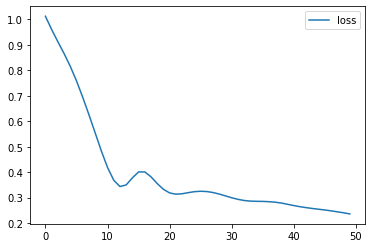

In [14]:
loss = history.history['loss']
plt.plot(loss,label='loss')
plt.legend()
plt.show()

In [16]:
#Planilha com os dados preenchidos

df_previsoes = pd.DataFrame({'Ano':anos_para_prever, 'Fofa_art':prev_ausentes.flatten()})

df_preenchido = pd.concat((dados,df_previsoes)).sort_values('Ano')

df_preenchido.to_excel('/home/andre/Área de Trabalho/Reconstrução da Estatística Pesqueira BR/Rio de Janeiro/Peixes/Sciaenidae/Fofa/Extrapolações Fofa_art.xlsx')

df_preenchido

,Ano,Fofa_art
67,2017,0.148400
68,2018,0.153200
69,2019,0.040600
70,2020,0.105800
71,2021,0.017700
0,2022,0.026594
